# Eye Movement — Desktop Activity Recognition

This notebook implements a full pipeline to load eye-tracking CSVs from the `dataset/` folder, create sliding-window features, train a RandomForest classifier, evaluate performance, and visualize results.

Sections:
1. Create and activate a virtual environment (venv)
2. Imports & kernel setup
3. Constants and dataset path checks
4. Load and combine CSVs
5. Quick inspection & cleaning
6. Compute velocities and sliding-window feature extraction
7. Training, evaluation, and visualizations


## Imports and configuration

This cell imports all libraries used in the notebook (data handling with pandas and numpy, ML tools from scikit-learn, plotting with matplotlib/seaborn, and joblib for saving models). It also sets plotting style and a reproducible random seed so downstream results are consistent across runs.

In [1]:
# 2 — Imports
import os
import re
import glob
import json
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style="whitegrid")
%matplotlib inline

SEED = 42
np.random.seed(SEED)


## Project constants and dataset checks

This cell defines project-level constants (like `DATA_DIR` and `SEED`) and performs quick filesystem sanity checks: it asserts the dataset directory exists, collects `.csv` file paths, and prints a small sample list so you can confirm the expected input files are available before running expensive processing.

In [2]:
# 3 — Constants and dataset path checks
ROOT = Path('.')
DATA_DIR = ROOT / 'dataset'
print('Project root:', ROOT.resolve())
print('Dataset path:', DATA_DIR.resolve())

assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"
csv_files = list(DATA_DIR.rglob('*.csv'))
print(f'Found {len(csv_files)} CSV files (showing up to 10):')
for p in csv_files[:10]:
    print(' -', p.name)


Project root: D:\arfa\code\eye_movement
Dataset path: D:\arfa\code\eye_movement\dataset
Found 192 CSV files (showing up to 10):
 - P01_BROWSE.csv
 - P01_DEBUG.csv
 - P01_INTERPRET.csv
 - P01_PLAY.csv
 - P01_READ.csv
 - P01_SEARCH.csv
 - P01_WATCH.csv
 - P01_WRITE.csv
 - P02_BROWSE.csv
 - P02_DEBUG.csv


## Load and combine CSV files (`load_all_data`)

This cell implements `load_all_data`, which recursively finds `.csv` files in the dataset directory, reads each file into a DataFrame, extracts `user` and `task` from the filename, adds `source_file` and a `session_id` to track the recording, and concatenates all per-file DataFrames into a single combined table. It also verifies required columns (e.g., `x`, `y`) and reports files that fail to parse.

In [3]:
# 4 — Load and combine CSV files

def parse_user_task_from_filename(fname):
    # Support patterns like P01_READ.csv, P01-READ.csv, or P01_READ-v1.csv
    base = Path(fname).stem
    # normalize separators
    parts = re.split('[-_]', base)
    if len(parts) >= 2:
        user = parts[0]
        task = parts[1]
    else:
        user = base
        task = 'unknown'
    return user, task


def load_all_data(data_directory):
    data_directory = Path(data_directory)
    all_files = list(data_directory.rglob('*.csv'))
    if len(all_files) == 0:
        raise FileNotFoundError(f'No CSV files found in {data_directory}')
    dfs = []
    for i, fp in enumerate(sorted(all_files)):
        try:
            df = pd.read_csv(fp)
        except Exception as e:
            print(f'Warning: failed to read {fp}: {e}')
            continue
        user, task = parse_user_task_from_filename(fp.name)
        df['user'] = user
        df['task'] = task
        df['source_file'] = fp.name
        df['session_id'] = f'{user}__{task}__{i}'
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    # Ensure x/y exist
    if 'x' not in combined.columns or 'y' not in combined.columns:
        raise ValueError('Expected columns x and y in CSV files')
    return combined

# quick smoke load

df_raw = load_all_data(DATA_DIR)
print('Combined rows:', len(df_raw))

df_raw.head()


Combined rows: 1505813


,participant,set,activity,x,y,timestamp,user,task,source_file,session_id
0,P01,B,BROWSE,1016,459,0,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
1,P01,B,BROWSE,1001,464,36,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
2,P01,B,BROWSE,998,476,72,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
3,P01,B,BROWSE,1001,482,107,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
4,P01,B,BROWSE,1011,489,140,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0


## Compute per-user velocity and basic preprocessing

This cell sorts the data within each `user`+`session_id`, converts timestamps if present, computes per-user differences `dx`/`dy` (and `dt` when timestamps exist), and derives a `velocity` column (Euclidean distance or distance/dt). It also clips extreme velocity outliers and prepares the DataFrame for windowing by ensuring consistent ordering.

In [4]:
# 5 — Compute gaze velocity and basic preprocessing
# Ensure rows are ordered per session
cols_before = list(df_raw.columns)
if 'timestamp' in df_raw.columns:
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], errors='coerce')
    df_raw = df_raw.sort_values(['user', 'session_id', 'timestamp']).reset_index(drop=True)
else:
    df_raw = df_raw.sort_values(['user', 'session_id']).reset_index(drop=True)

# compute differences per user
df_raw[['dx', 'dy']] = df_raw.groupby('user')[['x', 'y']].diff().fillna(0)
if 'timestamp' in df_raw.columns:
    df_raw['dt'] = df_raw.groupby('user')['timestamp'].diff().dt.total_seconds().fillna(0)
    # avoid division by zero
    df_raw['dt'] = df_raw['dt'].replace(0, np.nan)
    df_raw['velocity'] = np.sqrt(df_raw['dx']**2 + df_raw['dy']**2) / df_raw['dt']
    df_raw['velocity'] = df_raw['velocity'].replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df_raw['velocity'] = np.sqrt(df_raw['dx']**2 + df_raw['dy']**2)

# clip extreme outliers to a reasonable quantile to avoid noisy features
vel_clip = df_raw['velocity'].quantile(0.999)
df_raw['velocity'] = df_raw['velocity'].clip(upper=vel_clip)

print('Computed velocity. Example:')
df_raw[['user','task','session_id','x','y','dx','dy','velocity']].head()


Computed velocity. Example:


,user,task,session_id,x,y,dx,dy,velocity
0,P01,BROWSE,P01__BROWSE__0,1016,459,0.0,0.0,0.000000e+00
1,P01,BROWSE,P01__BROWSE__0,1001,464,-15.0,5.0,4.392052e+08
2,P01,BROWSE,P01__BROWSE__0,998,476,-3.0,12.0,3.435921e+08
3,P01,BROWSE,P01__BROWSE__0,1001,482,3.0,6.0,1.916630e+08
4,P01,BROWSE,P01__BROWSE__0,1011,489,10.0,7.0,3.698956e+08


## Sliding-window feature extraction (`create_features_from_windows`)

This cell defines the sliding-window extractor that iterates each session, slides a fixed-size window (configurable `window_size` and `step_size`) and computes statistical features per window: mean/std/min/max for `x` and `y`, and mean/std/max for `velocity` (plus sample count). The output is a features DataFrame, a label array, and a list of feature names ready for model training.

In [5]:
# 6 — Create sliding-window features

def create_features_from_windows(df, window_size=50, step_size=25):
    """
    Converts time-series gaze data into windowed statistical features.
    Returns: X_df (DataFrame), y (np.array), feature_names (list)
    """
    feature_rows = []
    labels = []
    session_ids = []
    # group by session (user + session_id)
    grouped = df.groupby('session_id')
    for session, g in grouped:
        g = g.reset_index(drop=True)
        n = len(g)
        if n < window_size:
            continue
        for start in range(0, n - window_size + 1, step_size):
            win = g.iloc[start:start+window_size]
            feats = {}
            # x & y stats
            feats['x_mean'] = win['x'].mean()
            feats['x_std'] = win['x'].std()
            feats['x_min'] = win['x'].min()
            feats['x_max'] = win['x'].max()
            feats['y_mean'] = win['y'].mean()
            feats['y_std'] = win['y'].std()
            feats['y_min'] = win['y'].min()
            feats['y_max'] = win['y'].max()
            # velocity stats
            feats['vel_mean'] = win['velocity'].mean()
            feats['vel_std'] = win['velocity'].std()
            feats['vel_max'] = win['velocity'].max()
            # sample count
            feats['n_samples'] = len(win)
            feature_rows.append(feats)
            # label: task for the session (assume constant within session)
            labels.append(win['task'].iloc[0])
            session_ids.append(session)
    X_df = pd.DataFrame(feature_rows)
    feature_names = list(X_df.columns)
    y = np.array(labels)
    return X_df, y, feature_names

# quick run to create features
X_df, y, feature_names = create_features_from_windows(df_raw, window_size=50, step_size=25)
print('Features shape:', X_df.shape)
print('Number of labels:', len(y))
X_df.head()


Features shape: (59954, 12)
Number of labels: 59954


,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,vel_mean,vel_std,vel_max,n_samples
0,933.98,175.321686,425,1614,529.24,259.493113,101,1138,2.589553e+09,5.682575e+09,2.389982e+10,50
1,974.44,390.142055,352,1641,660.84,463.372304,101,1905,3.909478e+09,6.543616e+09,2.389982e+10,50
2,1269.20,444.470196,352,1753,504.12,495.064071,68,1905,2.760753e+09,4.496299e+09,1.918338e+10,50
3,1514.26,242.649055,537,1753,191.38,224.608675,68,1050,1.582220e+09,2.671137e+09,1.306895e+10,50
4,1582.86,115.921685,1386,1694,126.20,25.557458,84,184,8.455836e+08,1.516768e+09,8.962016e+09,50


## Encode labels, train and evaluate model

This cell encodes textual `task` labels to integers, prepares `X`/`y` (fills NaNs), splits into train/test with stratification to preserve class balance, trains a `RandomForestClassifier`, evaluates using accuracy and a classification report, saves the trained model and supporting objects (label encoder and feature names), and defines plotting utilities for confusion matrix and feature importances.

Train shape: (47963, 12) Test shape: (11991, 12)
Accuracy: 0.6297

Classification report:
              precision    recall  f1-score   support

      BROWSE       0.60      0.55      0.57      1707
       DEBUG       0.54      0.61      0.58      1217
   INTERPRET       0.57      0.57      0.57      1125
        PLAY       0.67      0.64      0.66      1671
        READ       0.76      0.91      0.83      1722
      SEARCH       0.58      0.46      0.52      1459
       WATCH       0.62      0.67      0.65      1990
       WRITE       0.60      0.52      0.56      1100

    accuracy                           0.63     11991
   macro avg       0.62      0.62      0.62     11991
weighted avg       0.63      0.63      0.62     11991

Saved model to rf_eye_tracking.joblib


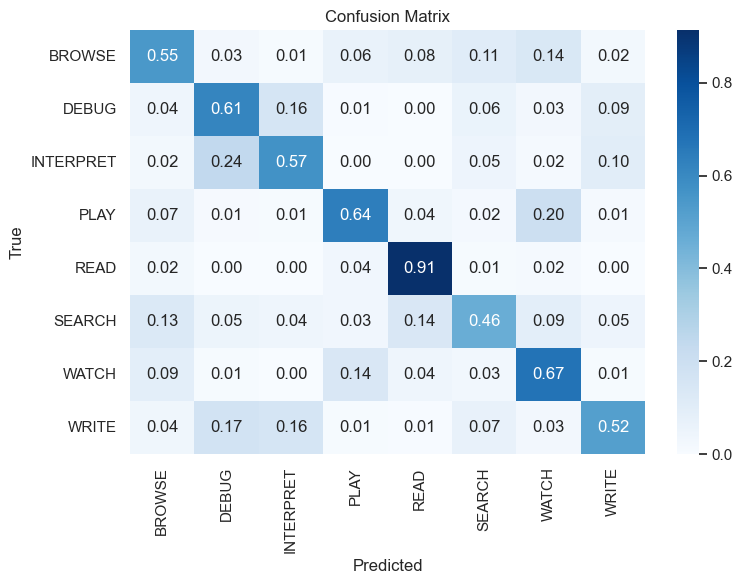

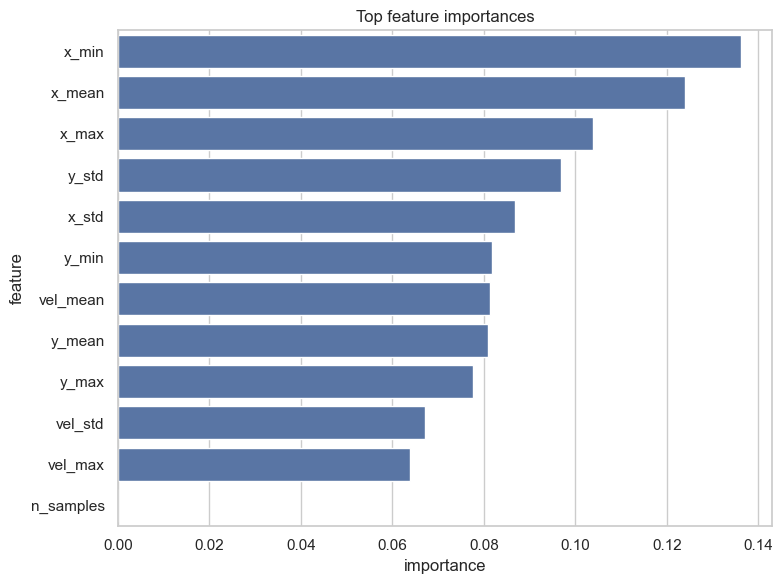

In [6]:
# 7 — Encode labels, split, train and evaluate
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# split
X = X_df.fillna(0).values
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# train
model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# metrics
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')
print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=class_names))

# save model
joblib.dump({'model': model, 'label_encoder': le, 'feature_names': feature_names}, 'rf_eye_tracking.joblib')
print('Saved model to rf_eye_tracking.joblib')

# 8 — Plotting utilities

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    return ax


def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi, ax=ax)
    ax.set_title('Top feature importances')
    plt.tight_layout()
    return ax

# show plots
plot_confusion_matrix(y_test, y_pred, class_names)
plot_feature_importance(model, feature_names, top_n=15)
plt.show()
